<a href="https://colab.research.google.com/github/gkv856/KaggleData/blob/main/NLP_Bert_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import tensorflow as tf
import tensorflow_hub as hub
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import random
import math
!pip install bert-for-tf2
!pip install tensorflow_text
import tensorflow_text as text 

In [25]:
TRAIN_URL = "https://raw.githubusercontent.com/gkv856/KaggleData/main/train.csv"
TEST_URL = "https://raw.githubusercontent.com/gkv856/KaggleData/main/test.csv"
SUBMISSION_URL = "https://raw.githubusercontent.com/gkv856/KaggleData/main/sample_submission.csv"


In [26]:
df_train_original = pd.read_csv(TRAIN_URL)


In [27]:
mispell_dict = {"aren't" : "are not",
                "ain't": "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"}

def replace_typical_misspell(text):
    mispellings_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))

    def replace(match):
        return mispell_dict[match.group(0)]

    return mispellings_re.sub(replace, text)


def clean_text(text_str):
  text_str = BeautifulSoup(text_str, "lxml").get_text()
  text_str = re.sub(r"@[A-Za-z0-9]+", " ", text_str)
  text_str = re.sub(r"https?://[[A-Za-z0-9./]+", " ", text_str)
  text_str = re.sub(r"[^a-zA-Z.!?']", " ", text_str)
  text_str = re.sub(r" +", " ", text_str)
  text_str = text_str.lower()
  # text_str = replace_typical_misspell(text_str)

  return text_str

In [28]:
df_train = df_train_original.copy()
df_train["text"] = df_train["text"].apply(clean_text)

In [29]:
df_train["text_len"] = df_train["text"].map(len)

In [30]:
from sklearn.model_selection import train_test_split

data = df_train["text"].values
labels = df_train["target"].values
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.3, random_state=42)

In [31]:
import bert

# will use this tokenizer to convert sentence to tokens
FullTokenizer = bert.bert_tokenization.FullTokenizer

BERT_PP_MODEL_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
# BERT_MODEL_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
BERT_MODEL_URL = "https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/4"
# preprocessor = hub.load(BERT_PP_MODEL_URL)
# tokenize = hub.KerasLayer(preprocessor.tokenize)

In [32]:
X_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# y_train_ds = tf.data.Dataset.from_tensor_slices(y_train)

X_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# y_test_ds = tf.data.Dataset.from_tensor_slices(y_test)

# X_train_ds, y_train_ds, X_test_ds, y_test_ds

In [33]:
BATCH_SIZE = 32
# train_dataset = train_dataset.batch(BATCH_SIZE).map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
X_train_ds_bp = X_train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# y_train_ds_bp = y_train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

X_test_ds_bp = X_test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# y_test_ds_bp = y_test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# X_train_ds_bp, y_train_ds_bp, X_test_ds_bp, y_test_ds_bp

In [34]:
import tensorflow.keras.layers as layers

In [35]:
bert_preprocessor = hub.KerasLayer(BERT_PP_MODEL_URL)
# bert_encoder_NT = hub.KerasLayer(BERT_MODEL_URL, trainable=False)
bert_encoder_T = hub.KerasLayer(BERT_MODEL_URL, trainable=True)

In [36]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import *

--2021-09-16 19:37:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-16 19:37:59 (81.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [37]:
lr = 0.001
input_layer = layers.Input(shape=(), dtype=tf.string, name="batched_text_inputs_layer")
encoder_inputs = bert_preprocessor(input_layer)
bert_outputs = bert_encoder_T(encoder_inputs)
sequence_output = bert_outputs["sequence_output"]

tf_model_output = tf.keras.layers.Dense(512, activation = 'relu')(sequence_output[:, 0, :])
tf_model_output = tf.keras.layers.Dropout(0.2)(tf_model_output)

tf_model_output = tf.keras.layers.Dense(256, activation = 'relu')(tf_model_output)
tf_model_output = tf.keras.layers.Dropout(0.1)(tf_model_output)

tf_model_output = tf.keras.layers.Dense(64, activation = 'relu')(tf_model_output)


outputs = layers.Dense(1, activation="sigmoid", name="output")(tf_model_output)

model2 = tf.keras.Model(input_layer, outputs, name="model2_trainable")

model2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
               metrics=["accuracy"])

model2.summary()

Model: "model2_trainable"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
batched_text_inputs_layer (Inpu [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'input_mask': (None 0           batched_text_inputs_layer[0][0]  
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      {'pooled_output': (N 335141889   keras_layer_2[0][0]              
                                                                 keras_layer_2[0][1]              
                                                                 keras_layer_2[0][2]              
___________________________________________________________________________________

In [38]:
history_model2 = model2.fit(X_train_ds_bp,
                            validation_data=X_test_ds_bp,
                            epochs=5)
plot_loss_curves(history_model2)

Epoch 1/5


ResourceExhaustedError: ignored

In [ ]:
y_preds2 = model2.predict(X_test)
y_preds = tf.round(y_preds2)
y_preds
model2_results = calculate_results(y_true=y_test, y_pred=y_preds)
model2_results

{'accuracy': 83.27495621716288,
 'f1': 0.8313155159865531,
 'precision': 0.8329452705780617,
 'recall': 0.8327495621716288}

In [ ]:
df_test = pd.read_csv(TEST_URL)
real_test = df_test["text"].to_numpy()
y_preds2 = model2.predict(real_test) 
y_preds = tf.round(y_preds2)
y_preds = tf.cast(y_preds, dtype=tf.int32)
res = tf.squeeze(y_preds).numpy()
res
my_sub = pd.DataFrame({'id': df_test['id'],'target':res})
my_sub.head(20)
my_sub.to_csv("sub.csv", index=False)

In [ ]:
my_sub.head(20)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [ ]:
lr = 0.01
input_layer = layers.Input(shape=(), dtype=tf.string, name="batched_text_inputs_layer")
encoder_inputs = bert_preprocessor(input_layer)
bert_outputs = bert_encoder_NT(encoder_inputs)
sequence_output = bert_outputs["sequence_output"]


dense1 = layers.Dense(128, activation="relu")(sequence_output)
dropout1 = layers.Dropout(0.3)(dense1)

dense2 = layers.Dense(8, activation="relu")(dropout1)


pool1 = layers.GlobalAveragePooling1D()(dense2)
# pool1 = layers.GlobalMaxPool1D()(dense2)

# pool1 = layers.Flatten()(dense2)

outputs = layers.Dense(1, activation="sigmoid", name="output")(pool1)

model3 = tf.keras.Model(input_layer, outputs, name="model3")

model3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
               metrics=["accuracy"])

model3.summary()

Model: "model3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
batched_text_inputs_layer (Inpu [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           batched_text_inputs_layer[0][0]  
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'encoder_outputs':  335141889   keras_layer[1][0]                
                                                                 keras_layer[1][1]                
                                                                 keras_layer[1][2]                
_____________________________________________________________________________________________

Epoch 1/5
167/167 [==============================] - 404s 2s/step - loss: 0.2965 - accuracy: 0.8778 - val_loss: 0.4093 - val_accuracy: 0.8284
Epoch 2/5
167/167 [==============================] - 406s 2s/step - loss: 0.2615 - accuracy: 0.8979 - val_loss: 0.4284 - val_accuracy: 0.8266
Epoch 3/5
167/167 [==============================] - 406s 2s/step - loss: 0.2361 - accuracy: 0.9116 - val_loss: 0.4386 - val_accuracy: 0.8249
Epoch 4/5
167/167 [==============================] - 407s 2s/step - loss: 0.2059 - accuracy: 0.9229 - val_loss: 0.4529 - val_accuracy: 0.8257
Epoch 5/5
167/167 [==============================] - 406s 2s/step - loss: 0.1857 - accuracy: 0.9300 - val_loss: 0.4734 - val_accuracy: 0.8236


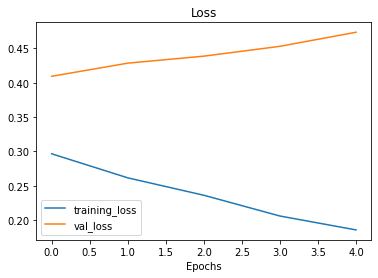

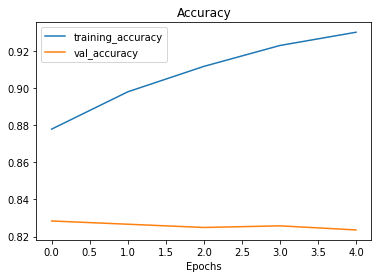

In [ ]:
history_model2 = model2.fit(X_train_ds_bp,
                            validation_data=X_test_ds_bp,
                            epochs=5)
plot_loss_curves(history_model2)